In [58]:
#必要なライブラリをインポート
import pandas as pd
import numpy as np
np.random.seed(1337)
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, Add
from keras.layers import Conv1D, MaxPooling1D, Embedding,Conv2D
from keras.models import Model
from keras.callbacks import EarlyStopping
import gensim
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import codecs
import matplotlib.pyplot as plt
from keras.layers import Concatenate
from subprocess import check_output


stop_words = (stopwords.words('english'))[:]
stop_words.extend(["#ff", "ff", "rt"])
stop_words.remove('not')
stop_words.remove('no')


In [59]:
import pandas as pd


df1 = pd.read_csv("labeled_data.csv", index_col=False)
df1.drop(['Unnamed: 0'], axis=1, inplace=True)
df1.sort_index(inplace=True)

df2 = pd.read_csv('hatespeech-train.csv',index_col=False)
df2.drop(['Unnamed: 0'], axis=1, inplace=True)
df_test = pd.read_csv('hatespeech-test.csv',index_col=False)
df_test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [60]:
df= pd.concat([df1.tweet,df2.tweet])
add=[]
for idx, i in enumerate(df):
    for j in df_test.tweet:
        if i==j:
            add.append(idx)
y=pd.concat([df1["class"],df2["class"]])

In [61]:
if add !=[]:
    print("重複データあり")

重複データあり


In [62]:
#除去
df0 = df.iloc[list(set(range(len(df.values)))  - set(add))]
y=  y.iloc[list(set(range(len(df.values)))  - set(add))]

In [63]:
df=df0

In [64]:
df.reset_index(inplace=True,drop=True)

In [65]:
y.reset_index(inplace=True,drop=True)
df_train= pd.concat([df, y],axis=1)

In [66]:
#Nan値除去
df_train= df_train[~df_train.isnull().any(axis=1)]
y= y[~df_train.isnull().any(axis=1)]

In [67]:
df_train.columns=['text','class']

In [68]:
df_test.columns= ["count","hate_speech","offensive_language","neither","class","text"]

In [69]:
df_train[df_train["class"]==2].count()

text     7375
class    7375
dtype: int64

In [70]:
add0= df_train[df_train["class"]==0].sample(20646,replace=True)
add2= df_train[df_train["class"]==2].sample(15825,replace=True)

In [71]:
df_train= pd.concat([df_train,add0,add2])

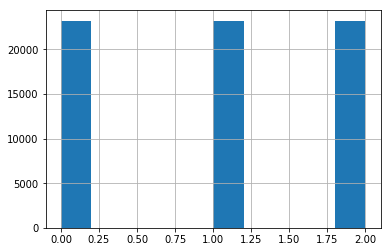

In [72]:
df_train["class"].hist()

In [73]:
from keras.utils import to_categorical
encoded = to_categorical(df_train['class'])
encoded2= to_categorical(df_test['class'])
y_e = pd.DataFrame(encoded)
y_e.columns=["hate_speech", "offensive_language", "neither"]
y_e2 = pd.DataFrame(encoded2)
y_e2.columns=["hate_speech", "offensive_language", "neither"]
df_train.reset_index(inplace=True,drop=True)
df_train = pd.concat([df_train["text"],y_e],axis=1)
df_test = pd.concat([df_test["text"],y_e2],axis=1)

In [74]:
EMBEDDING_DIM = 300
MAX_VOCAB_SIZE = 24000
MAX_SEQUENCE_LENGTH = 83

batch_size = 64

In [75]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "")
    df[text_field] = df[text_field].str.replace(r"!", "")
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ")
    df[text_field] = df[text_field].str.replace(r"@[\w\-]+", " ")
    df[text_field] = df[text_field].str.replace(r'\s+', ' ')
    df[text_field] = df[text_field].str.replace(r'^[! ]*RT', '')
    df[text_field] = df[text_field].str.replace(r'^[! ]*rt', '')
    return df

In [76]:
train_comments = standardize_text(df_train, "text")
train_comments.to_csv("train_clean_data.csv")
train_comments.head()

,text,hate_speech,offensive_language,neither
0,as a woman you shouldn't complain about clean...,0.0,0.0,1.0
1,boy dats cold tyga dwn bad for cuffin dat hoe...,0.0,1.0,0.0
2,dawg rt you ever fuck a bitch and she start t...,0.0,1.0,0.0
3,she look like a tranny,0.0,1.0,0.0
4,the shit you hear about me might be true or i...,0.0,1.0,0.0


In [77]:
label_names = ["hate_speech", "offensive_language", "neither"]
y_train = train_comments[label_names].values

In [78]:
test_comments = standardize_text(df_test, "text")
test_comments.to_csv("test_clean_data.csv")
test_comments.head()

,text,hate_speech,offensive_language,neither
0,still really confused re humplayproblems i thi...,1.0,0.0,0.0
1,stoni is a fuckin queer,1.0,0.0,0.0
2,stu a rape faced faggot man i'm sick of this n...,1.0,0.0,0.0
3,stuck up serious bitches are possibly the wors...,1.0,0.0,0.0
4,stupid teabagger restaurant making customers p...,1.0,0.0,0.0


In [79]:
label_names = ["hate_speech", "offensive_language", "neither"]
y_test = test_comments[label_names].values

In [80]:
tokenizer = RegexpTokenizer(r'\w+')
clean_train_comments = pd.read_csv("train_clean_data.csv")
clean_train_comments['text'] = clean_train_comments['text'].astype('str') 
clean_train_comments.dtypes
clean_train_comments["tokens"] = clean_train_comments["text"].apply(tokenizer.tokenize)

clean_train_comments["tokens"] = clean_train_comments["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])
   
clean_train_comments.head()

,Unnamed: 0,text,hate_speech,offensive_language,neither,tokens
0,0,as a woman you shouldn't complain about clean...,0.0,0.0,1.0,"[woman, complain, cleaning, house, amp, man, a..."
1,1,boy dats cold tyga dwn bad for cuffin dat hoe...,0.0,1.0,0.0,"[boy, dats, cold, tyga, dwn, bad, cuffin, dat,..."
2,2,dawg rt you ever fuck a bitch and she start t...,0.0,1.0,0.0,"[dawg, ever, fuck, bitch, start, cry, confused..."
3,3,she look like a tranny,0.0,1.0,0.0,"[look, like, tranny]"
4,4,the shit you hear about me might be true or i...,0.0,1.0,0.0,"[shit, hear, might, true, might, faker, bitch,..."


In [81]:
clean_test_comments = pd.read_csv("test_clean_data.csv")
clean_test_comments['text'] = clean_test_comments['text'].astype('str') 
clean_test_comments.dtypes
clean_test_comments["tokens"] = clean_test_comments["text"].apply(tokenizer.tokenize)
clean_test_comments["tokens"] = clean_test_comments["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])

clean_test_comments.head()

,Unnamed: 0,text,hate_speech,offensive_language,neither,tokens
0,0,still really confused re humplayproblems i thi...,1.0,0.0,0.0,"[still, really, confused, humplayproblems, thi..."
1,1,stoni is a fuckin queer,1.0,0.0,0.0,"[stoni, fuckin, queer]"
2,2,stu a rape faced faggot man i'm sick of this n...,1.0,0.0,0.0,"[stu, rape, faced, faggot, man, sick, nigga]"
3,3,stuck up serious bitches are possibly the wors...,1.0,0.0,0.0,"[stuck, serious, bitches, possibly, worst, typ..."
4,4,stupid teabagger restaurant making customers p...,1.0,0.0,0.0,"[stupid, teabagger, restaurant, making, custom..."


In [82]:
all_training_words = [word for tokens in clean_train_comments["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in clean_train_comments["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s 単語数, 語彙総数 %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("文の最大長さ %s" % max(training_sentence_lengths))

581074 単語数, 語彙総数 20431
文の最大長さ 83


In [83]:
all_test_words = [word for tokens in clean_test_comments["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in clean_test_comments["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s 単語数, 語彙総数 %s" % (len(all_test_words), len(TEST_VOCAB)))
print("文の最大長さ %s" % max(test_sentence_lengths))

7699 単語数, 語彙総数 2962
文の最大長さ 23


In [84]:
word2vec_path = "GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged


In [85]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(clean_train_comments["text"].tolist())
training_sequences = tokenizer.texts_to_sequences(clean_train_comments["text"].tolist())

train_word_index = tokenizer.word_index
print('%s ユニックなトークン' % len(train_word_index))

train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

21205 ユニックなトークン
(21206, 300)


In [86]:
test_sequences = tokenizer.texts_to_sequences(clean_test_comments["text"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [87]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)
    x = Flatten()(l_merge)
    x = Dense(128, activation='relu')(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = keras.models.Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    model.summary()
    return model

In [88]:
x_train = train_cnn_data
x_test = test_cnn_data

In [89]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)), False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 83)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 83, 300)      6361800     input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 81, 128)      115328      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 80, 128)      153728      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_12 

In [90]:
hist = model.fit(x_train, y_train, epochs=10,  validation_split=0.1,shuffle=True, batch_size=batch_size)

Train on 62640 samples, validate on 6960 samples
Epoch 1/10
62640/62640 [==============================] - 150s 2ms/step - loss: 0.3029 - acc: 0.8826 - val_loss: 0.1782 - val_acc: 0.9412
Epoch 2/10
62640/62640 [==============================] - 146s 2ms/step - loss: 0.0796 - acc: 0.9749 - val_loss: 0.0239 - val_acc: 0.9938
Epoch 3/10
62640/62640 [==============================] - 164s 3ms/step - loss: 0.0489 - acc: 0.9865 - val_loss: 0.0138 - val_acc: 0.9970
Epoch 4/10
62640/62640 [==============================] - 145s 2ms/step - loss: 0.0365 - acc: 0.9898 - val_loss: 0.0094 - val_acc: 0.9980
Epoch 5/10
62640/62640 [==============================] - 146s 2ms/step - loss: 0.0294 - acc: 0.9917 - val_loss: 0.0079 - val_acc: 0.9980
Epoch 6/10
62640/62640 [==============================] - 152s 2ms/step - loss: 0.0265 - acc: 0.9933 - val_loss: 0.0342 - val_acc: 0.9879
Epoch 7/10
62640/62640 [==============================] - 172s 3ms/step - loss: 0.0212 - acc: 0.9945 - val_loss: 0.0198 - v

In [91]:
y_pred = model.predict(x_test, batch_size=1024, verbose=1)

1040/1040 [==============================] - 2s 2ms/step


In [92]:

submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_comments.index.values 
submission_df[label_names] = y_pred 
submission_df.to_csv("./cnn_submission.csv", index=False)

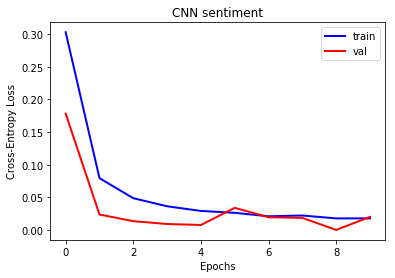

In [93]:
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

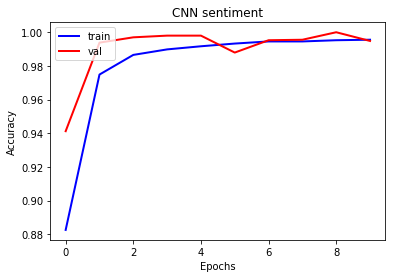

In [94]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [95]:
from sklearn.metrics import classification_report
report = classification_report(np.argmax(y_test,axis =1), np.argmax(y_pred,axis =1))

In [96]:
print(report)

              precision    recall  f1-score   support

           0       0.46      0.35      0.40       140
           1       0.73      0.90      0.81       500
           2       0.95      0.76      0.84       400

   micro avg       0.77      0.77      0.77      1040
   macro avg       0.71      0.67      0.68      1040
weighted avg       0.78      0.77      0.76      1040



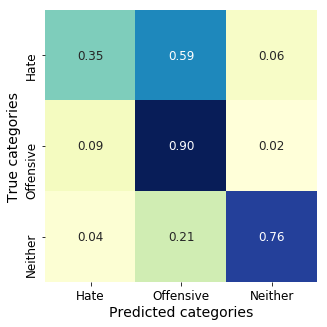

In [97]:
import seaborn
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.argmax(y_test,axis =1),np.argmax(y_pred,axis =1))
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

In [34]:
import os
import re
import csv
import codecs
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.layers import LSTM, Bidirectional, Dropout


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    


def LsTM(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False):
    
        #パラメータ
    act = 'relu'
    re_weight = True
    num_lstm = 300
    num_dense = 150
    
    sequence_1_input = Input(shape=(max_sequence_length,), dtype='int32')
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)
    
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    
    lstm_layer = LSTM(num_lstm,return_sequences=True)
    
    x1 = lstm_layer(embedded_sequences_1)
    
    merged = Attention(max_sequence_length)(x1)

    merged = Dense(num_dense, activation=act)(merged)

    preds = Dense(3, activation='softmax')(merged)


    model = Model(sequence_1_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [35]:
model = LsTM(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)), False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 83)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 83, 300)           6361800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 83, 300)           721200    
_________________________________________________________________
attention_1 (Attention)      (None, 300)               383       
_________________________________________________________________
dense_1 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 453       
Total params: 7,128,986
Trainable params: 767,186
Non-trainable params: 6,361,800
____________________________________________________________

In [94]:
hist = model.fit(x_train, y_train, epochs=10,  validation_split=0.1,shuffle=True, batch_size=batch_size,verbose=1)

Train on 62640 samples, validate on 6960 samples
Epoch 1/10
62640/62640 [==============================] - 285s 5ms/step - loss: 0.0318 - acc: 0.9908 - val_loss: 0.0078 - val_acc: 0.9990
Epoch 2/10
62640/62640 [==============================] - 289s 5ms/step - loss: 0.0252 - acc: 0.9931 - val_loss: 0.0201 - val_acc: 0.9953
Epoch 3/10
62640/62640 [==============================] - 297s 5ms/step - loss: 0.0244 - acc: 0.9929 - val_loss: 0.0229 - val_acc: 0.9941
Epoch 4/10
62640/62640 [==============================] - 313s 5ms/step - loss: 0.0200 - acc: 0.9944 - val_loss: 0.0271 - val_acc: 0.9922
Epoch 5/10
62640/62640 [==============================] - 295s 5ms/step - loss: 0.0206 - acc: 0.9937 - val_loss: 0.0122 - val_acc: 0.9954
Epoch 6/10
62640/62640 [==============================] - 298s 5ms/step - loss: 0.0134 - acc: 0.9964 - val_loss: 0.0036 - val_acc: 0.9994
Epoch 7/10
62640/62640 [==============================] - 283s 5ms/step - loss: 0.0193 - acc: 0.9939 - val_loss: 0.0135 - v

In [95]:
y_pred = model.predict(x_test, batch_size=1024, verbose=1)

1040/1040 [==============================] - 2s 2ms/step


In [96]:
submission_df = pd.DataFrame(columns=['id'] + label_names)
submission_df['id'] = test_comments.index.values 
submission_df[label_names] = y_pred 
submission_df.to_csv("./lstm_submission.csv", index=False)

In [97]:
from sklearn.metrics import classification_report
report = classification_report(np.argmax(y_test,axis =1), np.argmax(y_pred,axis =1))

In [98]:
print(report)

              precision    recall  f1-score   support

           0       0.61      0.34      0.43       140
           1       0.78      0.93      0.85       500
           2       0.94      0.86      0.90       400

   micro avg       0.82      0.82      0.82      1040
   macro avg       0.78      0.71      0.73      1040
weighted avg       0.82      0.82      0.81      1040



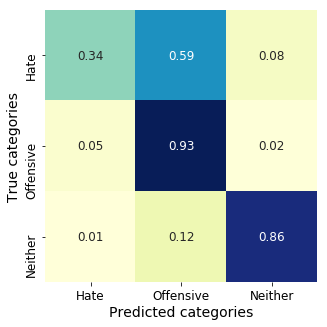

In [99]:
import seaborn
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.argmax(y_test,axis =1),np.argmax(y_pred,axis =1))
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5, 5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)